In [1]:
# TODO update the README.md file with installation instuctions. 


import os
import sys
import warnings
import numpy as np
import matplotlib.pylab as plt
import astropy.units as u
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
import importlib

import SAGE1
importlib.reload(SAGE1)
from SAGE1.sage import sage_class


## Input spectrum

[0.01153  0.015155 0.019492 0.022382 0.025453 0.0361   0.04947  0.051207
 0.047491 0.060118 0.089628 0.107163 0.109615 0.113086 0.117569 0.114926
 0.115816 0.113529 0.105465 0.101408 0.093657 0.081716 0.079929 0.096168
 0.128403 0.160723 0.169568 0.169357 0.181517 0.182638 0.160687 0.148416
 0.1457   0.137081 0.123015 0.100924 0.08382  0.084309 0.093852 0.100302
 0.097147 0.096005 0.093844 0.084059 0.086701 0.096172 0.105246 0.119264
 0.129692 0.139948 0.137449 0.123769 0.139158 0.166877 0.160039 0.124312
 0.088685 0.073746 0.088946 0.109409 0.111871 0.120982 0.137402 0.151579
 0.182417 0.227243 0.233887 0.207167 0.204365 0.200753 0.158738 0.113101
 0.083001 0.072754 0.08677  0.128448 0.195931 0.239833 0.221183 0.194629
 0.169998 0.121909 0.093564 0.105417 0.120109 0.118862 0.124607 0.137338
 0.156739 0.186045 0.212026 0.185121 0.132247 0.136097 0.174333 0.174816
 0.189038 0.285008 0.385611 0.437725 0.469109 0.461569 0.401625 0.370635
 0.386766 0.386737 0.384005 0.44455  0.506917 0.492

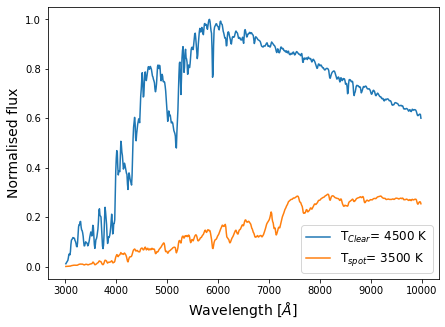

In [3]:
wavelength, flux_hot, flux_cold= np.loadtxt('input_spectrum.txt').T
plt.figure(figsize=(7,5))
plt.plot(wavelength, flux_hot, label= 'T$_{Clear}$= 4500 K')
plt.plot(wavelength, flux_cold, label= 'T$_{spot}$= 3500 K')
plt.xlabel('Wavelength [$\AA$]', fontsize= 14)
plt.ylabel('Normalised flux', fontsize=14)
plt.legend(fontsize=12)

In [3]:
u1, u2= np.loadtxt('ldc.txt').T


planet_pixel_size = 30

# Spot parameters
spotnumber = 2
spot_long= [0, 40] # in degress
spot_lat = [0, 30] # in degress
spot_size = [4, 2] # in degress
inclination= 90    # in degress
ve = 0.0 #km sec^{-1}


params=[0.1,                                       # Radius-ratio 
        20.0,                                      # scaled semi-major axis 
        u1,                                        # U1
        u2,                                        # U2
        0.0,                                       # cosine of angular distance
        0.0,                                       # Intensity profile 
        inclination]                               # Stellar Inclination [90 deg is Face-on and 0 is edge-on] 

Delta_rotAngle= 20 # in degress
rotational_angle= np.arange(0, 360+Delta_rotAngle, Delta_rotAngle)

In [4]:
star= sage_class(params, planet_pixel_size, wavelength, flux_hot, flux_cold, 
                 spot_lat, spot_long, spot_size, ve, spotnumber, 'multi-color', 5200, phases_rot=rotational_angle)

star_nold= sage_class(params, planet_pixel_size, wavelength, flux_hot, flux_cold, 
                      spot_lat, spot_long, spot_size, ve, spotnumber, 'single', 5200, phases_rot=rotational_angle)

flux_norm, contamination_factors, star_maps= star.rotate_star()

flux_norm_nold, contamination_factors_nold, star_maps_nold= star_nold.rotate_star()

Rotating the star
Rotating the star


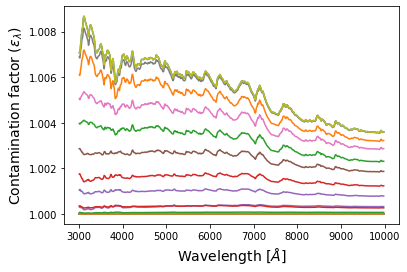

In [5]:
for i in range(len(contamination_factors)):
    # plt.figure(figsize=(8, 6))
    plt.plot(wavelength, contamination_factors[i])
    plt.xlabel('Wavelength [$\AA$]', fontsize=14)
    plt.ylabel('Contamination factor ($\epsilon_{\lambda}$)', fontsize=14)


### Animations

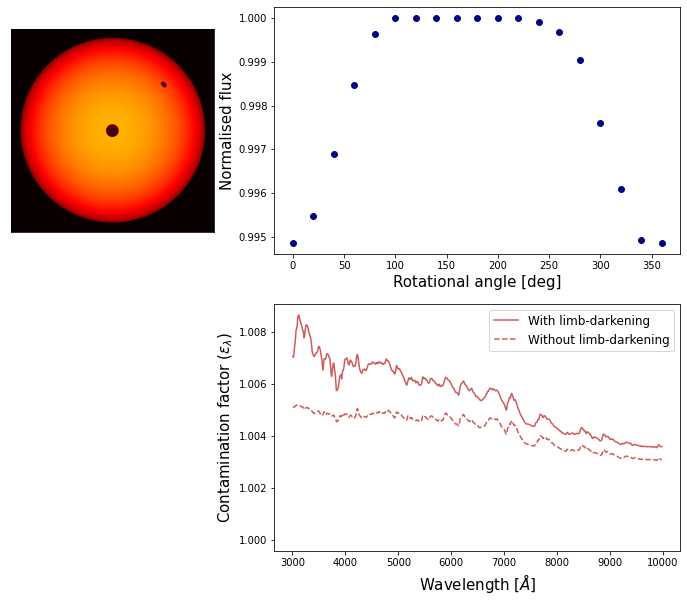

In [10]:
fig = plt.figure(figsize = (12,10))
gs = gridspec.GridSpec(2,2, width_ratios = [0.5, 1], height_ratios = [1, 1])

imgs= []
for i in range(len(rotational_angle)):
    
    # star
    ax0 = plt.subplot(gs[0, 0])   
    img0= ax0.imshow(star_maps[i].T, cmap=cm.hot, origin='lower', vmin=0.0, vmax=1.)
    ax0.set_xticks([])
    ax0.set_yticks([])
    
    # norm flux
    ax1= plt.subplot(gs[0,1])
    img1= ax1.scatter(rotational_angle[0:i+1], flux_norm[0:i+1], color = 'Navy', s = 35)
    ax1.set_xlabel('Rotational angle [deg]', fontsize=15)
    ax1.set_ylabel('Normalised flux', fontsize=15)
    
    # contamination factor
    ax2= plt.subplot(gs[1,1])
    img2,= ax2.plot(wavelength, contamination_factors[i], color = 'indianred', lw=1.5)
    img3,= ax2.plot(wavelength, contamination_factors_nold[i], color= 'indianred', lw=1.5, linestyle='dashed')
    
    
    ax2.set_xlabel('Wavelength [$\AA$]', fontsize=15)
    ax2.set_ylabel('Contamination factor ($\epsilon_{\lambda}$)', fontsize=15)
    
    
    imgs.append([img0, img1, img2, img3])
ax2.plot([], [], color = 'indianred', lw=1.5, label= 'With limb-darkening')
ax2.plot([], [], c='indianred', lw=1.5, label= 'Without limb-darkening', linestyle='dashed')
ax2.legend(fontsize=12)
ani = animation.ArtistAnimation(fig, imgs, interval=300, blit=False, repeat = True, repeat_delay =0)

ani.save(f'rotating_star.gif', dpi= 300)
    
plt.show()    
